<h1>Two-way repeated measures ANOVA with pingouin</h1>

In [1]:
#!pip install pingouin
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pingouin import rm_anova
from scipy.stats import levene

*__Load the dataset__.*

In [36]:
df_original=pd.read_excel('C:\\Users\\Robert\\Downloads\\Alle Dateien\\Bachelorarbeit Dateien.xlsx')
df_complete=df_original[df_original.columns[:5]]
#include a 'person' indicator to identify individuals taking repeated measures
df_complete.insert(0, 'Person', df_complete.index)
#rename columns and values from german to english
df_complete.columns=['Person', 'Gender', 'Age', 'Text_variant', 'T1Affect', 'T2Affect']
df_complete.loc(df_complete['Gender'].replace(['weiblich', 'männlich'], ['female', 'male'], inplace=True))
df_complete.loc(df_complete['Text_variant'].replace(['Kontrollgruppe', 'Versuchsgruppe'], ['gender neutral', 'generic masculine'], inplace=True))
df_complete.head()

,Person,Gender,Age,Text_variant,T1Affect,T2Affect
0,0,female,18,gender neutral,76,86
1,1,male,18,generic masculine,76,74
2,2,female,18,generic masculine,73,75
3,3,female,19,generic masculine,50,55
4,4,male,19,generic masculine,85,86


*__Plot Boxplots for repeated measures.__* 

Text(0.5, 1.0, 'T2Affect\n')

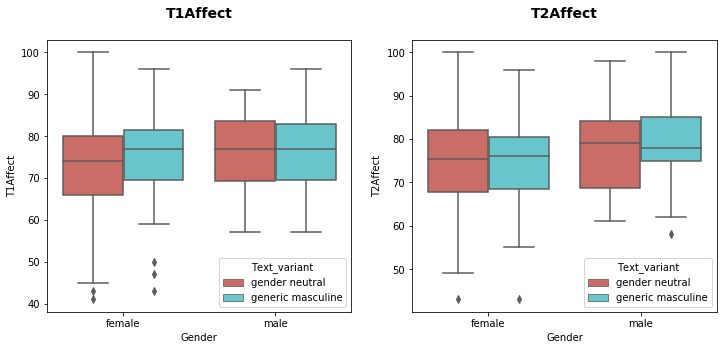

In [19]:
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(12,5))
sns.boxplot(x='Gender', y='T1Affect', hue='Text_variant', data=df_complete, ax=ax1, palette='hls')
sns.boxplot(x='Gender', y='T2Affect', hue='Text_variant', data=df_complete, ax=ax2, palette='hls')
ax1.set_title('T1Affect\n', fontdict={'fontsize':'14','fontweight':'bold'})
ax2.set_title('T2Affect\n', fontdict={'fontsize':'14','fontweight':'bold'})

There seems to be a signifcant overlap of the data.

*__Check preconditions for application of ANOVA.__*

First: Homoscedasticity and indepence of residuals:

Text(0.5, 1.0, 'T2Affect\n')

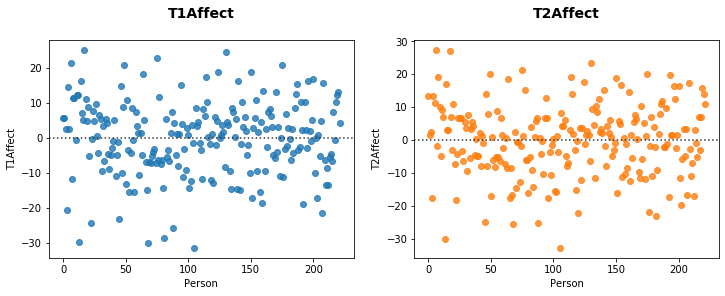

In [20]:
%matplotlib inline
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(12, 4))
sns.residplot(x=df_complete['Person'], y=df_complete['T1Affect'], ax=ax1)
sns.residplot(x=df_complete['Person'], y=df_complete['T2Affect'], ax=ax2)
ax1.set_title('T1Affect\n', fontdict={'fontsize':'14','fontweight':'bold'})
ax2.set_title('T2Affect\n', fontdict={'fontsize':'14','fontweight':'bold'})

→ The residuals are spread unsymmetrically. Therefore, we do not assume homoscedasticity or dependency of residuals. ANOVA can be applied.

Second, check variance homogeneity:

In [21]:
df_K_fem=df_complete.loc[df_complete['Gender']=='female'].loc[df_complete['Text_variant']=='gender neutral']
df_K_mas=df_complete.loc[df_complete['Gender']=='male'].loc[df_complete['Text_variant']=='gender neutral']
df_V_fem=df_complete.loc[df_complete['Gender']=='female'].loc[df_complete['Text_variant']=='generic masculine']
df_V_mas=df_complete.loc[df_complete['Gender']=='male'].loc[df_complete['Text_variant']=='generic masculine']

In [24]:
print('Comparison of variance inhomogeneity for male and female subgroups:')
print('Variance inhomogeneity m/f control group (T1): p =', levene(df_K_mas['T1Affect'], df_K_fem['T1Affect'], center='mean')[1])
print('Variance inhomogeneity m/f control group (T2): p =', levene(df_K_mas['T2Affect'], df_K_fem['T2Affect'], center='mean')[1])
print('Variance inhomogeneity m/f experimental group (T1): p =', levene(df_V_mas['T1Affect'], df_V_fem['T1Affect'], center='mean')[1])
print('Variance inhomogeneity m/f experimental group (T2): p =', levene(df_V_mas['T2Affect'], df_V_fem['T2Affect'], center='mean')[1])

Comparison of variance inhomogeneity for male and female subgroups:
Variance inhomogeneity m/f control group (T1): p = 0.724081327596023
Variance inhomogeneity m/f control group (T2): p = 0.9459548579843959
Variance inhomogeneity m/f experimental group (T1): p = 0.7641227450179134
Variance inhomogeneity m/f experimental group (T2): p = 0.19400283640026805


→ None of the Levene tests ↑ is significant. Therefore, the unequal unbalanced group sizes can be ignored and ANOVA can be applied.

*__Plotting possible interactions.__*

Text(0.5, 1.0, 'Differences in affective response (T1/T2) \nin control-/experimental group by gender\n')

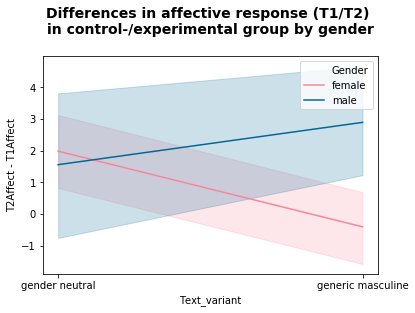

In [27]:
df_with_diff=df_complete.copy()
df_with_diff['T2Affect - T1Affect']=df_with_diff['T2Affect']-df_with_diff['T1Affect']
sns.lineplot(x='Text_variant', y='T2Affect - T1Affect', hue='Gender', data=df_with_diff, palette=('#f7879a', '#016795'))
plt.title('Differences in affective response (T1/T2) \nin control-/experimental group by gender\n', fontdict={'fontsize':'14','fontweight':'bold'})
#Die Schattierung um die Linien sind Konfidenzintervalle

→ In the control there is no difference between affective responses (T1/T2) in men and women. In the experimental condition, there is a tendency for men to respond with increased emotions and women to respond with decreased emotions.

*__Apply two-way repeated measures ANOVA.__*

In [28]:
complete_test_df=df_complete.melt(id_vars=['Person', 'Gender', 'Text_variant'], value_vars=['T1Affect', 'T2Affect'], value_name='Affective score')

In [30]:
aov = complete_test_df.rm_anova(dv='Affective score',
                  within=['Gender', 'Text_variant'],
                  subject='Person')
aov

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,Gender,2489.196334,1,221,2489.196334,-10.681824,1.0,1.0,-0.050789,1.0
1,Text_variant,489.846815,1,221,489.846815,-2.186970,1.0,1.0,-0.009995,1.0
2,Gender * Text_variant,-674.636774,1,221,-674.636774,-5.921165,1.0,NaN,-0.027530,NaN


→ There are no significant effects for main effects or interactions. At least for interactions, a larger sample size could lead to significant results (as per assessment of the above displayed plot).
Post-hoc tests will not be applied, due to insignificant interactions.